In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f #For activation function
import torch.optim as optim
from torch.utils.data import (Dataset, DataLoader)   #For creating your own Dataset
import torchvision.transforms as transforms

from sklearn.utils import shuffle
from PIL import Image 
from glob import glob
from skimage import io
import cv2

### GETTING DATASET FROM DRIVE
1.Unzip it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/BrainTumor/Brain_Tumor-20220810T050449Z-001.zip"

**Handling of the CPU and CUDA**

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
  

###CUSTOM DATA GENERATOR

In [4]:
class Braintumor(Dataset):

  def __init__(self,data_dir , reshape = True , height = 128 , width = 128 
               ,autoencoder = False ,  transform = None):
    self.dataDirectory = data_dir  #DEFINING THE PARENT DIRECTORY '/content/Brain_Tumor'
    self.no_class =  glob(data_dir + "/no/*")   #GETTING PATH OF IMAGES HAVING NO LABEL
    self.yes_class = glob(data_dir + "/yes/*")   #GETTING PATH OF IMAGES HAVING YES LABEL
    self.width = width
    self.height = height
    self.transform = transform
    self.reshape = True

    labels = [0 for i in self.no_class]         #MAKING A LABEL LIST FOR GROUND TRUTH 
    labels += [1 for i in self.yes_class]       # HERE + IS USED TO JOIN BOTH LIST
    self.images_path = self.no_class + self.yes_class

    self.dataFrame = pd.DataFrame({"images_path" : self.images_path , "labels" : labels })
    self.dataFrame.reset_index(inplace = True , drop = True)
    #print(self.dataFrame["images_path"][20])

  def __len__(self):
      return len(self.dataFrame)

  def __getitem__(self,idx):
    image_filepath = self.dataFrame["images_path"][idx]
    y_label  = self.dataFrame["labels"][idx]      
    
    #Image Pixel Reading 
    image = Image.open(image_filepath).convert("L")
    y_label = torch.tensor(int(y_label))

    if self.reshape:
      image = image.resize((self.height , self.width))

    image_array = np.array(image)

    if self.transform:
        image = self.transform(image_array)

    return (image, y_label)


In [5]:
data_directory = "/content/Brain_Tumor"
dataset = Braintumor(data_directory , transform=transforms.ToTensor())

In [6]:
len(dataset)

253

### DEFINING TRAIN AND TEST SIZE

In [7]:
trainset = np.floor(0.8*len(dataset))
testset = len(dataset) - trainset

In [8]:
print(trainset , testset)

202.0 51.0


### TRAIN _ TEST SPLIT

In [9]:
train_set, val_set = torch.utils.data.random_split(dataset, [202, 51])

### TRAIN TEST LOADER

In [10]:
trainloader = torch.utils.data.DataLoader(train_set , batch_size = 32 , shuffle =True)
testloader = torch.utils.data.DataLoader(val_set , batch_size = 32 , shuffle = False)

## Visualization Dataset

In [11]:
dataiter = iter(trainloader)
images,labels = dataiter.next()  #Get instance of the images

print(images.shape)

print(labels[0].item())  #Doubt

torch.Size([32, 1, 128, 128])
1


In [12]:
def imshow(img):
  npimg = img.numpy()
  npimg = np.transpose(npimg , (1,2,0))
  plt.imshow(npimg)
  plt.show()

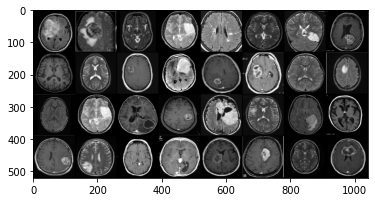

1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1


In [13]:
import torchvision
imshow(torchvision.utils.make_grid(images))
print(" ".join([str(labels[j].item()) for j in range(32)]))

## DEFINING MODEL

In [24]:
class BrainTumorModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,256,kernel_size=3), #126*126*256
        nn.ReLU(),
        nn.MaxPool2d(2,2),              #63*63*256
        nn.Conv2d(256,64,kernel_size=3),  #61*61*64
        nn.ReLU(),
        nn.Conv2d(64,32,kernel_size=3),   #59*59*32
        nn.ReLU(),
    )

    self.linear =  nn.Sequential(       
            nn.Flatten(),
            nn.Linear(111392,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.linear(x)
    return x


In [25]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=111392, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [27]:
def evaluation(dataloader):
  with torch.no_grad():
    total, correct = 0, 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)        
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

### EVALUTIONS AND RESULT

Epoch [1/10] Train Acuuracy: 61.8812 Test Acuuracy: 58.8235 Train-Loss: 0.6594
Epoch [2/10] Train Acuuracy: 78.7129 Test Acuuracy: 76.4706 Train-Loss: 1.0181
Epoch [3/10] Train Acuuracy: 78.7129 Test Acuuracy: 76.4706 Train-Loss: 0.4749
Epoch [4/10] Train Acuuracy: 71.2871 Test Acuuracy: 72.5490 Train-Loss: 0.4970
Epoch [5/10] Train Acuuracy: 83.1683 Test Acuuracy: 82.3529 Train-Loss: 0.4002
Epoch [6/10] Train Acuuracy: 87.6238 Test Acuuracy: 86.2745 Train-Loss: 0.2093
Epoch [7/10] Train Acuuracy: 87.6238 Test Acuuracy: 82.3529 Train-Loss: 0.3050
Epoch [8/10] Train Acuuracy: 88.1188 Test Acuuracy: 84.3137 Train-Loss: 0.5065
Epoch [9/10] Train Acuuracy: 95.5446 Test Acuuracy: 82.3529 Train-Loss: 0.0483
Epoch [10/10] Train Acuuracy: 97.0297 Test Acuuracy: 84.3137 Train-Loss: 0.0189


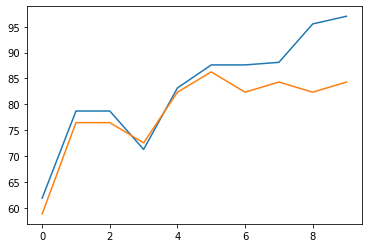

In [28]:
num_epochs = 10
final_loss = []
train_acc = []
test_acc= []
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
  
	#Load in the data in batches using the train_loader object
  for i, (images, labels) in enumerate(trainloader):  
      # Move tensors to the configured device
      images = images.to(device)
      labels = labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      # Backward and optimize
      optimizer.zero_grad() #clear the gradients
      loss.backward()       #calculate the gradients
      optimizer.step()
  
  #After Every Epoch
  final_loss.append(loss.item())
  train_accuracy = evaluation(trainloader)
  test_accuracy = evaluation(testloader)
  train_acc.append(train_accuracy)
  test_acc.append(test_accuracy)
  print('Epoch [{}/{}] Train Acuuracy: {:.4f} Test Acuuracy: {:.4f} Train-Loss: {:.4f}'
        .format(epoch+1, num_epochs ,train_accuracy, test_accuracy ,loss.item()))
      
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()